# Notebook 5a: SPH-projection on the GPU + orientation class

Here we compare the CPU and GPU implementations of SPH projection.

This notebook requires that you have the GPU requirements installed and available on your system
and that you have modified your Paicos user settings to load GPU functionality on startup.
Please see the details here: https://paicos.readthedocs.io/en/latest/installation.html#gpu-cuda-requirements 

In [1]:
import paicos as pa
import numpy as np
pa.use_units(True)

In [2]:
# Load snapshot
snap = pa.Snapshot(pa.data_dir, 247)

### Initialize orientation

Here we use a Paicos orientation class to initialize the view such that the 
width of the image is along the $x$-coordinate of the simulation and the height
of the image is along the $y$-coordinate. The depth of the image is in the $z$-direction.

The orientation class has methods for rotating the view around $x$, $y$, and $z$
or around the axes of its local coordinate system. When an orientation
instance has been passed to an ImageCreator (such as the projector below),
then calling these methods will result in a rotation around the center of
the image.

In [3]:
# Do some arbitrary orientation
orientation = pa.Orientation(normal_vector=[0, 0, 1], perp_vector1=[1, 0, 0])
orientation.rotate_around_normal_vector(degrees=20)  # Image depth direction
orientation.rotate_around_perp_vector1(degrees=35)  # Image width direction
orientation.rotate_around_perp_vector2(degrees=-47)  # Image height direction

### Initialize projectors

In [4]:
# Pixels along horizontal direction
npix = 256

# Center of projection
center = snap.Cat.Group['GroupPos'][0]\

R200c = snap.Cat.Group['Group_R_Crit200'][0]

# Widths of projection (width, height and depth)
widths = np.array([10000, 10000, 10000]) * R200c.uq

projector = pa.NestedProjector(snap, center, widths, orientation,
                               npix=npix, factor=2, npix_min=npix // 16,
                               store_subimages=True)

gpu_projector = pa.GpuSphProjector(snap, center, widths, orientation,
                                   npix=npix, threadsperblock=8,
                                   do_pre_selection=False)

Attempting to get derived variable: 0_Volume...	[DONE]

Attempting to get derived variable: 0_Volume...	[DONE]



### Project density and display it

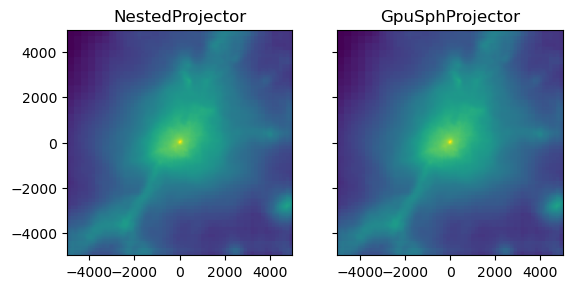

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

dens = projector.project_variable(
    '0_Masses') / projector.project_variable('0_Volume')
gpu_dens = gpu_projector.project_variable(
    '0_Masses') / gpu_projector.project_variable('0_Volume')


plt.figure(1)
plt.clf()
fig, axes = plt.subplots(num=1, ncols=2, sharex=True, sharey=True)
axes[0].imshow(
    dens.value, extent=projector.centered_extent.value, norm=LogNorm())
axes[1].imshow(
    gpu_dens.value, extent=projector.centered_extent.value, norm=LogNorm())

axes[0].set_title('NestedProjector')
axes[1].set_title('GpuSphProjector')
plt.show()